## Codes for TBM simulatin engine

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.integrate import quad
from scipy.stats import gamma
from typing import List, Tuple, Dict, Any, Optional
import warnings
import os
import time
from multiprocessing import Pool, cpu_count
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
import json


## Failure Intensity Functions
'''
Maintenance Strategy Modeling:
- Minimal CM (Corrective Maintenance) for minor failures: As-Good-As-Old (AGAO), does not affect failure intensity
- PM (Preventive Maintenance): range from AGAO to As-Good-As-New (AGAN), the level depends on the 'push' parameter

Failure Types:
- Minor failures: Caused by cumulative damage/material aging
  PM changes virtual age by "restoring/slowing degradation"
- Catastrophic failures: Fatal shocks
  The arrival rate of such shocks is typically NOT directly changed by PM (PM improves "internal state" rather than external shock arrival process)
'''

# =========================================
# Failure intensity (hazard) and integrals
# =========================================

def lambda_f(
    machine_id, t, pm_affects=True, T=None, push=0.0, scale=None, intercept=None, shape=None,
    fixed_covs=None, dynamic_cov_t=None, beta_fixed=None, beta_dynamic=None, model_type="weibull", with_covariates=True
):
    """
    Unified hazard function for both minor and catastrophic failures
    
    Parameters:
    -----------
    machine_id : int
        Machine identifier
    t : float
        Absolute Time or time since last catastrophic failure
    pm_affects : bool
        True -> minor failure (affected by PM), False -> catastrophic failure (not affected by PM)
    T : float
        PM interval/time
    push : float
        PM effectiveness parameter (0=AGAO, 1=AGAN)
    scale, intercept, shape : float
        Parameters for hazard function based on model_type
    fixed_covs : array-like
        Fixed covariates for all machines
    dynamic_cov_t : array-like
        Dynamic covariates at time t
    beta_fixed, beta_dynamic : array-like
        Coefficients for fixed and dynamic covariates
    model_type : str
        Type of hazard model: 'linear', 'log-linear', or 'weibull'
    with_covariates : bool
        Whether to include covariate effects
    
    Returns:
    --------
    float : Hazard rate at time t
    """
    # Calculate virtual time V_t
    if pm_affects and T is not None:
        time_in_cycle = t % T  # Time since last PM
        completed_cycles = np.floor(t / T)
        V_t = time_in_cycle + (1 - push) * T * completed_cycles
    else:
        V_t = t

    # Baseline hazard
    if model_type == "linear":
        hazard = intercept + scale * V_t
    elif model_type == "log-linear":
        hazard = np.exp(intercept + scale * V_t)
    elif model_type == "weibull":
        if shape is None or scale is None:
            raise ValueError("Weibull requires shape and scale parameters")
        hazard = (shape / scale) * (V_t / scale) ** (shape - 1)
    else:
        raise ValueError("model_type must be 'linear', 'log-linear', or 'weibull'")

    if not with_covariates:
        return hazard

    # # Add covariate effects
    cov_effect = 0.0
    
    if fixed_covs is not None and beta_fixed is not None and len(beta_fixed) > 0:
        cov_effect += np.dot(fixed_covs[machine_id-1], beta_fixed)
    
    if dynamic_cov_t is not None and beta_dynamic is not None and len(beta_dynamic) > 0:
        cov_effect += np.dot(dynamic_cov_t, beta_dynamic)

    return hazard * np.exp(cov_effect)

def integrated_lambda_closed(b, shape, scale, model_type="weibull", intercept=None):
    """
    Closed-form cumulative hazard Λ(b) for catastrophic failures
    Only applicable when pm_affects=False and with_covariates=False
    
    Parameters:
    -----------
    b : float
        Upper bound of integration interval [0, b]
    
    Returns:
    --------
    float : Cumulative hazard over [0, b]
    """
    if model_type == "linear":
        return intercept * b + 0.5 * scale * b**2
    elif model_type == "log-linear":
        return (np.exp(intercept) / scale) * (np.exp(scale * b) - 1)
    elif model_type == "weibull":
        if shape is None:
            raise ValueError("Weibull requires shape parameter")
        return (b / scale) ** shape
    else:
        raise ValueError("model_type must be 'linear', 'log-linear', or 'weibull'")


def integrated_lambda_numeric(machine_id, a, b,
                              pm_affects=True, T=None, push=0.0, scale=None, intercept=None, shape=None,
                              fixed_covs=None, dynamic_cov_t=None, beta_fixed=None, beta_dynamic=None,
                              model_type="weibull", with_covariates=True):
    """
    Numerical integration of hazard function over interval [a, b]
    
    Parameters:
    -----------
    a, b : float
        Integration interval bounds
    pm_affects : bool
        True -> minor failure (affected by PM), False -> catastrophic failure
    (other parameters same as lambda_f)
    
    Returns:
    --------
    float : Integrated hazard over [a, b]
    """
    integrand = lambda t: lambda_f(
        machine_id, t, pm_affects=pm_affects, T=T, push=push,
        scale=scale, intercept=intercept, shape=shape,
        fixed_covs=fixed_covs, dynamic_cov_t=dynamic_cov_t,
        beta_fixed=beta_fixed, beta_dynamic=beta_dynamic,
        model_type=model_type, with_covariates=with_covariates
    )

    result, _ = quad(integrand, a, b)
    return result

def compute_cumulative_integrals(
    cumulative_integrals, machine_id, valid_indices, m, delta_t, shape, scale, intercept=None,
    fixed_covs=None, dynamic_covs=None, beta_fixed=None, beta_dynamic=None, model_type="weibull",
    with_covariates=True, pm_affects=False, T=None, push=0.0
):
    """
    Update cumulative integrals (applicable for both minor and catastrophic failures)
    
    Parameters:
    -----------
    cumulative_integrals : list
        Existing cumulative integral values
    valid_indices : int
        Last failure index in the time series
    m : int
        Total number of discretized time intervals
    delta_t : float
        Time interval length
    pm_affects : bool
        True -> minor failure (affected by PM), False -> catastrophic failure (not affected by PM)
  
    Returns:
    --------
    list : Updated cumulative integral values
    """
    if len(cumulative_integrals) == 0:
        kept_integrals = [0]
        cumulative_value = 0
        start_index = 0
    else:
        kept_integrals = cumulative_integrals[:valid_indices+1]
        cumulative_value = cumulative_integrals[valid_indices]
        start_index = valid_indices

    for i in range(start_index, m):
        time_start = i * delta_t
        time_end = (i + 1) * delta_t

        if with_covariates:
            # With covariates -> numerical integration
            dynamic_cov_t = dynamic_covs[i] if dynamic_covs is not None else None
            integral_val = integrated_lambda_numeric(
                machine_id, time_start, time_end,
                pm_affects=pm_affects, T=T, push=push,
                scale=scale, intercept=intercept, shape=shape,
                fixed_covs=fixed_covs, dynamic_cov_t=dynamic_cov_t,
                beta_fixed=beta_fixed, beta_dynamic=beta_dynamic,
                model_type=model_type, with_covariates=True
            )
            cumulative_value += integral_val
        else:
            if pm_affects:
                # Minor failure: affected by PM, no closed-form solution, must use numerical integration
                integral_val = integrated_lambda_numeric(
                    machine_id, time_start, time_end,
                    pm_affects=True, T=T, push=push,
                    scale=scale, intercept=intercept, shape=shape,
                    fixed_covs=None, dynamic_cov_t=None,
                    beta_fixed=None, beta_dynamic=None,
                    model_type=model_type, with_covariates=False
                )
                cumulative_value += integral_val
            else:
                # Catastrophic failure: no covariates -> can use closed-form solution Λ(b)
                Λ_b = integrated_lambda_closed(
                    time_end, shape, scale, model_type=model_type, intercept=intercept
                )
                cumulative_value = Λ_b

        kept_integrals.append(cumulative_value)

    return kept_integrals

# =========================================
# Failure time 
# =========================================
def getFailureTime(
    s, cumulative_integrals_minor, cumulative_integrals_catas, cumulative_integrals,
    dynamic_covs_changed, machine_id, valid_indices, m, delta_t,
    # Minor failure parameters
    include_minor=True,
    model_type_minor="linear", shape_minor=None, scale_minor=None, intercept_minor=None,
    fixed_covs=None, dynamic_covs=None, beta_fixed=None, beta_dynamic=None,
    with_covariates_minor=True, T=None, push=0.0,
    # Catastrophic failure parameters
    include_catas=True,
    model_type_catas="linear", shape_catas=None, scale_catas=None, intercept_catas=None,
    with_covariates_catas=False
):
    """
    General version: supports only-minor / only-catastrophic / both failure types
    
    Parameters:
    -----------
    s : float
        Cumulative hazard threshold (transformed from uniform random variable)
    cumulative_integrals_minor/catas : list
        Cumulative integrals for minor and catastrophic failures
    dynamic_covs_changed : bool
        Flag indicating if dynamic covariates have changed
    include_minor : bool
        Whether to include minor failures (pm_affects=True)
    include_catas : bool
        Whether to include catastrophic failures (pm_affects=False)
    
    Returns:
    --------
    tuple : 
        - valid_indices: time index of failure
        - ft: failure time
        - cumulative_integrals_*: updated cumulative integrals
        - is_censored: whether observation is censored
    """
    u = np.random.uniform(0, 1)
    s = s - np.log(u)

    # Step 1: Update cumulative integrals
    if (len(cumulative_integrals_minor) == 0 or dynamic_covs_changed or len(cumulative_integrals_catas) == 0):

        if include_minor:
            cumulative_integrals_minor = compute_cumulative_integrals(
                cumulative_integrals_minor, machine_id, valid_indices, m, delta_t,
                shape=shape_minor, scale=scale_minor, intercept=intercept_minor,
                fixed_covs=fixed_covs, dynamic_covs=dynamic_covs, beta_fixed=beta_fixed, beta_dynamic=beta_dynamic,
                model_type=model_type_minor, with_covariates=with_covariates_minor,
                pm_affects=True, T=T, push=push
            )

        if include_catas:
            cumulative_integrals_catas = compute_cumulative_integrals(
                cumulative_integrals_catas, machine_id, valid_indices, m, delta_t,
                shape=shape_catas, scale=scale_catas, intercept=intercept_catas,
                fixed_covs=fixed_covs, dynamic_covs=dynamic_covs, beta_fixed=beta_fixed, beta_dynamic=beta_dynamic,
                model_type=model_type_catas, with_covariates=with_covariates_catas,
                pm_affects=False, T=None, push=0.0
            )

        # Step 2: Combine (only add existing components)
        if include_minor and include_catas:
            cumulative_integrals = [mi + ca for mi, ca in zip(cumulative_integrals_minor, cumulative_integrals_catas)]
        elif include_minor:
            cumulative_integrals = cumulative_integrals_minor
        elif include_catas:
            cumulative_integrals = cumulative_integrals_catas
        else:
            raise ValueError("At least one of include_minor or include_catas must be True.")

    else:
        cumulative_integrals = cumulative_integrals

    # Step 3: Find failure time
    search_start = max(0, valid_indices + 1)
    candidates = np.where(np.array(cumulative_integrals[search_start:]) >= s)[0]

    if len(candidates) == 0:
        # Censored observation
        is_censored = True
        return valid_indices, -1, s, cumulative_integrals_minor, cumulative_integrals_catas, cumulative_integrals, is_censored

    valid_indices = candidates[0] + search_start  # cumulative_integrals start from index 0, so valid_indices is the actual time series index
    ft = valid_indices * delta_t  # ft records failure time at the right side of interval (reasonable, as failure hasn't occurred at left side)
    is_censored = False

    return valid_indices, ft, s, cumulative_integrals_minor, cumulative_integrals_catas, cumulative_integrals, is_censored

# =========================================
# Failure type 
# =========================================
'''
Failure Type Classification:
- minor vs. catastrophic → competing risks, hazard rates naturally determine the probabilities
- minor subtype → no separate subtype hazards; once a minor failure occurs, 
  covariates determine which specific minor type it belongs to (via multinomial logistic regression)
'''

def get_failure_type(
    machine_id, ft, T, push, scale, intercept, shape, with_covariates_minor, model_type_minor,
    fixed_covs, dynamic_cov_t, beta_fixed, beta_dynamic,
    scale_c, shape_c, intercept_c, model_type_catas, with_covariates_catas
):
    """
    Determine whether failure at time ft is minor or catastrophic
    
    Parameters:
    -----------
    machine_id : int
        Machine identifier
    ft : float
        Failure time
    (other parameters for hazard functions)
    
    Returns:
    --------
    tuple : (p_minor, type_risk)
        - p_minor: probability of being a minor failure
        - type_risk: 1=minor, 2=catastrophic
    """
    # Minor failure hazard
    lambda_minor = lambda_f(
        machine_id, ft, pm_affects=True, T=T, push=push,
        scale=scale, intercept=intercept, shape=shape,
        fixed_covs=fixed_covs, dynamic_cov_t=dynamic_cov_t, beta_fixed=beta_fixed, beta_dynamic=beta_dynamic,
        model_type=model_type_minor, with_covariates=with_covariates_minor
    )

    # Catastrophic failure hazard
    lambda_catastrophic = lambda_f(
        machine_id, ft, pm_affects=False, T=None, push=0.0,
        scale=scale_c, intercept=intercept_c, shape=shape_c,
        fixed_covs=fixed_covs, dynamic_cov_t=dynamic_cov_t, beta_fixed=beta_fixed, beta_dynamic=beta_dynamic,
        model_type=model_type_catas, with_covariates=with_covariates_catas
    )

    # Total hazard
    lambda_total = lambda_minor + lambda_catastrophic
    if lambda_total == 0:
        raise ValueError("lambda_total=0, hazard is zero everywhere")

    # Probability of minor failure
    p_minor = lambda_minor / lambda_total

    # Sample failure type
    is_minor = np.random.binomial(1, p_minor)
    # failure_type: 'minor' -> type_risk = 1; 'catastrophic' -> type_risk = 2
    type_risk = 1 if is_minor else 2
    return p_minor, type_risk

def get_minor_failure_type(machine_id, beta_multinom_fixed, beta_multinom_dynamic,
                           fixed_covs, dynamic_cov_t, n_minor_types):
    """
    Sample minor failure subtype using multinomial logistic regression with covariates
    
    Parameters:
    -----------
    beta_multinom_fixed : array-like
        Fixed covariate coefficients, shape (n_fixed_features, n_minor_types-1)
    beta_multinom_dynamic : array-like
        Dynamic covariate coefficients, shape (n_dynamic_features, n_minor_types-1)
    fixed_covs : array-like
        Fixed covariates for all machines, shape (n_machines, n_fixed_features)
    dynamic_cov_t : array-like
        Dynamic covariates at current time, shape (n_dynamic_features,)
    n_minor_types : int
        Number of minor failure types
    
    Returns:
    --------
    int : Minor failure subtype (1 to n_minor_types)
    """
    # Robustness: if someone sets n < 2, fall back to a single class
    if n_minor_types is None or n_minor_types < 2:
        return 1

    Jm1 = n_minor_types - 1  # constant length we must maintain

    # ----- Fixed part (length J-1) -----
    if (fixed_covs is not None) and (beta_multinom_fixed is not None):
        fixed_part = np.dot(fixed_covs[machine_id - 1], beta_multinom_fixed)  # -> (J-1,)
    else:
        fixed_part = np.zeros(Jm1, dtype=float)

    # ----- Dynamic part (length J-1) -----
    if (dynamic_cov_t is not None) and (beta_multinom_dynamic is not None):
        dyn = np.ravel(dynamic_cov_t)  
        dynamic_part = np.dot(dyn, beta_multinom_dynamic)  # -> (J-1,)
    else:
        dynamic_part = np.zeros(Jm1, dtype=float)

    # Combine fixed and dynamic parts
    logits = fixed_part + dynamic_part  # shape (J_minor_types-1,)

    # Numerical stability: append reference category (logit = 0)
    logits = np.append(logits, 0.0)
    logits = logits - np.max(logits)
    exp_logits = np.exp(logits)

    # Normalize to get probabilities
    probs = exp_logits / np.sum(exp_logits)
    
    # Sample category according to probabilities
    f_type = np.random.choice(len(probs), p=probs) + 1

    return f_type  # Returns category 1 to n_minor_types

# =========================================
# Simulation failures for Single Cycle: From AGAN State to Failure or Observation End 
# =========================================
def simulate_single_cycle(t_obs, machine_id, m, delta_t,
                          include_minor, T, push,
                          model_type_minor, shape_minor, scale_minor, intercept_minor,
                          with_covariates_minor, fixed_covs, dynamic_covs, beta_fixed, beta_dynamic,
                          include_catas, model_type_catas, shape_catas, scale_catas, intercept_catas,
                          with_covariates_catas, beta_multinom_fixed, beta_multinom_dynamic,
                          n_minor_types, cov_update_fn=None):
    """
    Simulate a single cycle from AGAN state until either catastrophic failure or observation end (which comes first)
    
    Parameters:
    -----------
    t_obs : float
        Observation time
    cov_update_fn : callable or None
        Custom function to update dynamic covariates.
        Function signature: cov_update_fn(dynamic_covs, failure_type, valid_indices, machine_id)
        Should return: (updated_dynamic_covs, was_updated)
        If None, no covariate update is performed.
    
    Returns:
    --------
    tuple : (failure_index, failure_time, risk_type, failure_type, censor_status, updated_dynamic_covs)
        - failure_index: list of failure indices
        - failure_time: list of failure times
        - risk_type: list of risk types (1=minor, 2=catastrophic)
        - failure_type: list of specific failure types (minor failure 1,2,...)
        - censor_status: list of censoring status (1=observed, 0=censored)
        - updated_dynamic_covs: updated dynamic covariates array
    """
    failure_index = []
    failure_time = []
    risk_type = []
    failure_type = []
    censor_status = []  # Censoring status: 1=observed failure, 0=censored

    s = 0
    cumulative_integrals_minor = []
    cumulative_integrals_catas = []
    cumulative_integrals = []
    cumulative_value = 0
    s_record = [0]

    valid_indices = -1  # Initial failure index
    ft = -1  # Initial failure time
    f_type = -1  # Initial minor failure type
    dynamic_covs_changed = False  # Flag for dynamic covariate change

    # Continue until failure time exceeds observation time
    while ft < t_obs:
        ###### Get failure time
        result = getFailureTime(s, cumulative_integrals_minor, cumulative_integrals_catas, cumulative_integrals,
                    dynamic_covs_changed, machine_id, valid_indices, m, delta_t,
                    # Minor failure parameters
                    include_minor=include_minor,
                    model_type_minor=model_type_minor, shape_minor=shape_minor, scale_minor=scale_minor, intercept_minor=intercept_minor,
                    fixed_covs=fixed_covs, dynamic_covs=dynamic_covs, beta_fixed=beta_fixed, beta_dynamic=beta_dynamic,
                    with_covariates_minor=with_covariates_minor, T=T, push=push,
                    # Catastrophic failure parameters
                    include_catas=include_catas,
                    model_type_catas=model_type_catas, shape_catas=shape_catas, scale_catas=scale_catas, intercept_catas=intercept_catas,
                    with_covariates_catas=with_covariates_catas)

        valid_indices, ft, s, cumulative_integrals_minor, cumulative_integrals_catas, cumulative_integrals, is_censored = result

        updated_dynamic_covs = dynamic_covs.copy() if dynamic_covs is not None else None  # Default: return initial values if not updated
        
        if is_censored:
            # Censored case: record censoring event and stop
            failure_index.append(m)  # the last time point
            failure_time.append(t_obs)  # Record observation end time
            risk_type.append(0)  # Censored event
            failure_type.append(0)  # Censored event
            censor_status.append(0)  # 0=censored
            break

        # Check if failure time exceeds observation time
        if ft >= t_obs:
            # No failure before observation end, record as censored
            failure_index.append(m)
            failure_time.append(t_obs)
            risk_type.append(0)
            failure_type.append(0)
            censor_status.append(0)
            break

        # Normal failure case
        failure_index.append(valid_indices)
        failure_time.append(ft)
        censor_status.append(1)  # 1=observed failure

        ##### Determine failure type
        dynamic_cov_t = dynamic_covs[valid_indices] if (dynamic_covs is not None) else None
        # If only one failure type is included, skip competing risk calculation
        if include_minor and not include_catas:
            # Only minor failures possible
            type_risk = 1
            p_minor = 1.0
        elif include_catas and not include_minor:
            # Only catastrophic failures possible
            type_risk = 2
            p_minor = 0.0
        else:
            # Both types included - use competing risks
            p_minor, type_risk = get_failure_type(
                machine_id, ft, T, push, scale_minor, intercept_minor, shape_minor,
                with_covariates_minor, model_type_minor,
                fixed_covs, dynamic_cov_t, beta_fixed, beta_dynamic,
                scale_catas, shape_catas, intercept_catas, model_type_catas, with_covariates_catas
            )
        
        risk_type.append(type_risk)
        
        # Continue even if catastrophic failure, as observation time is fixed
        if type_risk == 2:
            failure_type.append(-1)  # Ensure list lengths match
            break
        else:
            f_type = get_minor_failure_type(machine_id, beta_multinom_fixed, beta_multinom_dynamic, 
                                           fixed_covs, dynamic_cov_t, n_minor_types)
            failure_type.append(f_type)
            
            # Apply custom covariate update function if provided
            if cov_update_fn is not None and dynamic_covs is not None:
                updated_dynamic_covs, was_updated = cov_update_fn(
                    dynamic_covs, f_type, valid_indices, machine_id
                )
                if was_updated:
                    dynamic_covs = updated_dynamic_covs.copy()
                    dynamic_covs_changed = True

    return failure_index, failure_time, risk_type, failure_type, censor_status, updated_dynamic_covs

# =========================================
# Simulation failures for Complete Observation Period 
# =========================================
def simulation_complete_observed_period(
        t_obs, machine_id, m, n_dynamic_features, delta_t, T, push,
        include_minor, model_type_minor, shape_minor, scale_minor, intercept_minor,
        with_covariates_minor, include_catas, model_type_catas, shape_catas, scale_catas, intercept_catas,
        with_covariates_catas, fixed_covs, dynamic_covs, beta_fixed, beta_dynamic,
        beta_multinom_fixed, beta_multinom_dynamic, n_minor_types, cov_update_fn=None):
    """
    Complete observation period simulation, handling resets after catastrophic failures
    Supports both minor and catastrophic failures with optional covariates
    
    Returns:
    --------
    tuple : Complete simulation results including failure indices, times, types, and covariate trajectories
    """
    # Store results from all cycles
    all_failure_index = []
    all_real_failure_time = []
    all_abs_failure_time = []
    all_risk_type = []
    all_failure_type = []
    all_censor_status = []

    # allow missing dynamic covariates
    if dynamic_covs is not None:
        n_dynamic_features = dynamic_covs.shape[1]
        all_dynamic_covs = np.empty((0, n_dynamic_features), dtype=float)
        initial_dynamic_covs = dynamic_covs.copy()
    else:
        n_dynamic_features = 0
        all_dynamic_covs = None              # keep None to skip concatenations safely
        initial_dynamic_covs = None

    #updated_dynamic_covs = None

    t_obs_remain = t_obs
    current_time_offset = 0.0
    absolute_index_offset = 0

    while t_obs_remain > 0:
        # Current number of intervals
        current_m = (len(dynamic_covs) - 1) if (dynamic_covs is not None) else m

        # Run single cycle simulation
        failure_index, failure_time, risk_type, failure_type, censor_status, updated_dynamic_covs = simulate_single_cycle(
            t_obs_remain, machine_id, current_m, delta_t,
            include_minor, T, push,
            model_type_minor, shape_minor, scale_minor, intercept_minor,
            with_covariates_minor, fixed_covs, dynamic_covs, beta_fixed, beta_dynamic,
            include_catas, model_type_catas, shape_catas, scale_catas, intercept_catas,
            with_covariates_catas, beta_multinom_fixed, beta_multinom_dynamic,
            n_minor_types, cov_update_fn)

        # Adjust failure times and indices to absolute values
        abs_failure_time = [ft + current_time_offset if ft > 0 else ft for ft in failure_time]
        abs_failure_index = [fi + absolute_index_offset if fi > 0 else fi for fi in failure_index]

        # Save results
        all_failure_index.extend(abs_failure_index)
        all_real_failure_time.extend(failure_time)  #failure time in its cycle (restes if a catatrophic failure occurs)
        all_abs_failure_time.extend(abs_failure_time) #absolute failure time in the observation horizon
        all_risk_type.extend(risk_type)
        all_failure_type.extend(failure_type)
        all_censor_status.extend(censor_status)

        # Check for catastrophic failure
        if (len(failure_type) > 0 and failure_type[-1] == -1 and
            len(failure_time) > 0 and failure_time[-1] < t_obs_remain):
            catastrophic_time = all_abs_failure_time[-1]

            # Update remaining observation time and time offset
            t_obs_remain = t_obs - catastrophic_time
            current_time_offset = catastrophic_time

            # Update absolute index offset
            absolute_index_offset = abs_failure_index[-1]

            if initial_dynamic_covs is not None:
                # Reset dynamic_covs to AGAN state for remaining time
                dynamic_covs = initial_dynamic_covs[absolute_index_offset:].copy()
            if all_dynamic_covs is not None and updated_dynamic_covs is not None:
                # Truncate all_dynamic_covs: keep only pre-catastrophic portion
                k = int(failure_index[-1])
                all_dynamic_covs = np.concatenate((all_dynamic_covs, updated_dynamic_covs[:k]), axis=0)
        else:
            if all_dynamic_covs is not None and updated_dynamic_covs is not None:
                all_dynamic_covs = np.concatenate((all_dynamic_covs, updated_dynamic_covs), axis=0)
            break

    return (all_failure_index, all_real_failure_time, all_abs_failure_time,
            all_risk_type, all_failure_type, all_censor_status, all_dynamic_covs)

# =========================================
# Failure Cost Generation Functions 
# =========================================
def generate_gamma_cost(fixed_covs, dynamic_cov_t, gamma_coeffs_fixed, gamma_coeffs_dynamic,
                        machine_id, a, b, loc_fixed, use_covariates):
    """
    Generate cost from Gamma distribution with optional covariate effects
    
    Parameters:
    -----------
    gamma_coeffs_fixed : array-like
        Fixed covariate coefficients for location parameter
    gamma_coeffs_dynamic : array-like
        Dynamic covariate coefficients for location parameter
    a : float
        Gamma distribution shape parameter
    b : float
        Gamma distribution scale parameter
    loc_fixed : float
        Fixed location parameter when not using covariates
    use_covariates : bool
        Whether to use covariates to affect location parameter
    
    Returns:
    --------
    float : Generated cost from Gamma distribution
    """
    if use_covariates:
        loc = 0.0
        if fixed_covs is not None and gamma_coeffs_fixed is not None and len(gamma_coeffs_fixed) > 0:
            loc += np.dot(fixed_covs[machine_id - 1], gamma_coeffs_fixed)
        if dynamic_cov_t is not None and gamma_coeffs_dynamic is not None and len(gamma_coeffs_dynamic) > 0:
            loc += np.dot(dynamic_cov_t, gamma_coeffs_dynamic)
        loc = float(loc)
    else:
        loc = loc_fixed

    cost = gamma.rvs(a, loc=loc, scale=b)
    return cost

# Frank Copula sampling function
def frank_copula_sample(theta, u1):
    """
    Sample from Frank Copula given u1 (more robust implementation)
    
    Parameters:
    -----------
    theta : float
        Frank Copula dependence parameter
    u1 : float
        First uniform random variable in [0,1]
    
    Returns:
    --------
    float : Second uniform random variable u2 in [0,1] dependent on u1
    """
    if theta == 0:
        return np.random.uniform()

    w = np.random.uniform()
    e_neg_theta = np.exp(-theta)
    denom = np.exp(-theta * u1)

    numerator = w * (e_neg_theta - 1.0)
    denom_A = denom - w * (denom - 1.0)

    eps = 1e-14
    denom_A = np.maximum(denom_A, eps)
    inside = 1.0 + numerator / denom_A
    inside = np.maximum(inside, eps)

    u2 = -np.log(inside) / theta
    u2 = np.clip(u2, 0.0, 1.0)
    return u2

# Correlated cost generation using Frank Copula
def get_failure_costs_with_frank_copula(machine_id, dynamic_cov_t, fixed_covs, 
    gamma_coeffs_y1_fixed, gamma_coeffs_y1_dynamic, 
    gamma_coeffs_y2_fixed, gamma_coeffs_y2_dynamic, 
    theta, a1=2.0, a2=2.0, b1=1.0, b2=1.0, 
    loc_fixed1=0.0, loc_fixed2=0.0, use_covariates=True):
    """
    Generate two correlated failure costs using Frank Copula
    Supports both fixed and dynamic covariates
    
    Parameters:
    -----------
    gamma_coeffs_y1_fixed, gamma_coeffs_y2_fixed : array-like
        Fixed covariate coefficients for cost 1 and cost 2
    gamma_coeffs_y1_dynamic, gamma_coeffs_y2_dynamic : array-like
        Dynamic covariate coefficients for cost 1 and cost 2
    theta : float
        Frank Copula dependence parameter
    a1, a2 : float
        Gamma distribution shape parameters for cost 1 and 2
    b1, b2 : float
        Gamma distribution scale parameters for cost 1 and 2
    loc_fixed1, loc_fixed2 : float
        Fixed location parameters when not using covariates
    use_covariates : bool
        Whether to use covariates to affect location parameters
    
    Returns:
    --------
    tuple : (cost1, cost2) - Two correlated costs
    """
    # Calculate location parameters
    if use_covariates:
        loc1 = 0.0
        loc2 = 0.0
        
        if fixed_covs is not None and gamma_coeffs_y1_fixed is not None and len(gamma_coeffs_y1_fixed) > 0:
            loc1 += np.dot(fixed_covs[machine_id - 1], gamma_coeffs_y1_fixed)
        if dynamic_cov_t is not None and gamma_coeffs_y1_dynamic is not None and len(gamma_coeffs_y1_dynamic) > 0:
            loc1 += np.dot(dynamic_cov_t, gamma_coeffs_y1_dynamic)
            
        if fixed_covs is not None and gamma_coeffs_y2_fixed is not None and len(gamma_coeffs_y2_fixed) > 0:
            loc2 += np.dot(fixed_covs[machine_id - 1], gamma_coeffs_y2_fixed)
        if dynamic_cov_t is not None and gamma_coeffs_y2_dynamic is not None and len(gamma_coeffs_y2_dynamic) > 0:
            loc2 += np.dot(dynamic_cov_t, gamma_coeffs_y2_dynamic)
            
        loc1 = float(loc1)
        loc2 = float(loc2)
    else:
        loc1 = loc_fixed1
        loc2 = loc_fixed2

    # Copula sampling
    u1 = np.random.uniform()
    u2 = frank_copula_sample(theta, u1)

    cost1 = gamma.ppf(u1, a=a1, loc=loc1, scale=b1)
    cost2 = gamma.ppf(u2, a=a2, loc=loc2, scale=b2)

    return cost1, cost2

def simulate_failure_costs(
    machine_id, failure_index, failure_time, failure_type,
    fixed_covs, dynamic_covs, n_minor_types,
    gamma_coeffs_cat_fixed, gamma_coeffs_cat_dynamic,
    gamma_coeffs_minor_fixed_list,gamma_coeffs_minor_dynamic_list,
    theta_copula,
    shape_cat=2.0, scale_cat=1.0, loc_fixed_cat=0.0,
    shape_minor_list=None,  scale_minor_list=None, loc_fixed_minor_list=None,
    use_covariates=True, minor_combo_map=None
):
    """
    Generate maintenance costs per event.

    Rules
    -----
    - ftype == -1 : catastrophic → single Gamma cost.
    - ftype == 0  : censored     → cost = 0.
    - ftype in [1..n_minor_types]:
        * If `ftype` is in `minor_combo_map` as a PAIR (a, b), interpret the event as
          types `a` and `b` occurring simultaneously → generate TWO correlated Gamma
          costs via a Frank copula and sum them.
        * Otherwise, a single minor-type Gamma cost.

    Notes
    -----
    - Only PAIR combinations are supported in `minor_combo_map`. If a mapping has more
      or fewer than 2 components, a ValueError is raised.
    - `theta_copula` can be:
        * a single float (used for all pairs), or
        * a dict providing pair-specific values. The lookup will try:
            1) the composite type id (ftype), then
            2) the sorted component tuple, e.g. (min(a,b), max(a,b)).
      If neither key exists in the dict, a ValueError is raised.
    - `dynamic_covs[idx]` is used to fetch the dynamic covariate vector at the event time.
      If `idx` is out of bounds (e.g., censored rows), a zero-like vector is used.

    Expected shapes
    ---------------
    - fixed_covs:  (n_machines, n_fixed_features)
    - dynamic_covs: (n_time_steps, n_dynamic_features) or N-D with time on axis 0
    - *_list arguments: lists of length n_minor_types
    """
    # Defaults
    if shape_minor_list is None:
        shape_minor_list = [2.0] * n_minor_types
    if scale_minor_list is None:
        scale_minor_list = [1.0] * n_minor_types
    if loc_fixed_minor_list is None:
        loc_fixed_minor_list = [0.0] * n_minor_types
    if minor_combo_map is None:
        minor_combo_map = {}

    # Validate lengths
    if len(gamma_coeffs_minor_fixed_list) != n_minor_types:
        raise ValueError("len(gamma_coeffs_minor_fixed_list) must equal n_minor_types.")
    if len(gamma_coeffs_minor_dynamic_list) != n_minor_types:
        raise ValueError("len(gamma_coeffs_minor_dynamic_list) must equal n_minor_types.")
    if len(shape_minor_list) != n_minor_types:
        raise ValueError("len(shape_minor_list) must equal n_minor_types.")
    if len(scale_minor_list) != n_minor_types:
        raise ValueError("len(scale_minor_list) must equal n_minor_types.")
    if len(loc_fixed_minor_list) != n_minor_types:
        raise ValueError("len(loc_fixed_minor_list) must equal n_minor_types.")

    # Validate `minor_combo_map` keys and enforce pair-only combos
    for combo_type, comps in minor_combo_map.items():
        if not (1 <= combo_type <= n_minor_types):
            raise ValueError(f"minor_combo_map key out of range: {combo_type} not in 1..{n_minor_types}")
        if not isinstance(comps, (tuple, list)) or len(comps) != 2:
            raise ValueError(f"minor_combo_map[{combo_type}] must be a 2-tuple/list, e.g. (1, 3)")
        a, b = int(comps[0]), int(comps[1])
        if a == b:
            raise ValueError(f"minor_combo_map[{combo_type}] components must differ: ({a}, {b})")
        if not (1 <= a <= n_minor_types) or not (1 <= b <= n_minor_types):
            raise ValueError(f"minor_combo_map[{combo_type}] components out of range: ({a}, {b})")
   
    costs = []

    for j, ftype in enumerate(failure_type):
        idx = failure_index[j]     
        dynamic_cov_t = dynamic_covs[idx] if dynamic_covs is not None else None 


        if ftype == -1:  # catastrophic failure
            cost = generate_gamma_cost(
                fixed_covs, dynamic_cov_t, gamma_coeffs_cat_fixed, gamma_coeffs_cat_dynamic, machine_id,
                a=shape_cat, b=scale_cat, loc_fixed=loc_fixed_cat, use_covariates=use_covariates
            )
            costs.append(cost)
            continue

        if ftype == 0:  # truncated
            costs.append(0.0)
            continue

        # Composite minor type → PAIR only via minor_combo_map
        if ftype in minor_combo_map:
            a_type, b_type = minor_combo_map[ftype]
            i1 = int(a_type) - 1
            i2 = int(b_type) - 1

            # Resolve theta:
            # - if dict → must be keyed by composite ftype (int)
            # - if float → use the same value for all pairs
            if isinstance(theta_copula, dict):
                if ftype not in theta_copula:
                    raise ValueError(
                        f"No theta_copula provided for composite type {ftype}. "
                        f"Provide theta_copula as a float or a dict keyed by composite ftype, e.g. {{4: 1.5}}."
                    )
                theta_for_pair = float(theta_copula[ftype])
            else:
                theta_for_pair = float(theta_copula)

            # Two correlated Gamma costs via Frank copula, then sum
            c1, c2 = get_failure_costs_with_frank_copula(
                machine_id=machine_id,
                dynamic_cov_t=dynamic_cov_t,  # flattened internally
                fixed_covs=fixed_covs,
                gamma_coeffs_y1_fixed=gamma_coeffs_minor_fixed_list[i1],
                gamma_coeffs_y1_dynamic=gamma_coeffs_minor_dynamic_list[i1],
                gamma_coeffs_y2_fixed=gamma_coeffs_minor_fixed_list[i2],
                gamma_coeffs_y2_dynamic=gamma_coeffs_minor_dynamic_list[i2],
                theta=theta_for_pair,
                a1=shape_minor_list[i1], a2=shape_minor_list[i2],
                b1=scale_minor_list[i1], b2=scale_minor_list[i2],
                loc_fixed1=loc_fixed_minor_list[i1], loc_fixed2=loc_fixed_minor_list[i2],
                use_covariates=use_covariates
            )
            costs.append(float(c1 + c2))
        else:
            # Single minor type
            i0 = ftype - 1
            c = generate_gamma_cost(
                fixed_covs, dynamic_cov_t,
                gamma_coeffs_minor_fixed_list[i0], gamma_coeffs_minor_dynamic_list[i0],
                machine_id,
                a=shape_minor_list[i0], b=scale_minor_list[i0], loc_fixed=loc_fixed_minor_list[i0],
                use_covariates=use_covariates
            )
            costs.append(float(c))      
            
    return costs

# =========================================
# PM costs generation
# =========================================
def simulate_periodical_pm(t_obs, T, delta_t, machine_id, fixed_covs, dynamic_covs,
                           gamma_coeffs_pm_fixed, gamma_coeffs_pm_dynamic,
                           a=2.0, b=1.0, loc_fixed=0.0, use_covariates=True):
    """
    Simulate the complete process of periodical preventive maintenance (PM)
    
    Parameters:
    -----------
    T : float
        PM period (time between consecutive PMs)
    gamma_coeffs_pm_fixed, gamma_coeffs_pm_dynamic : array-like
        Coefficients for PM cost
    a : float
        Gamma shape parameter for PM cost
    b : float
        Gamma scale parameter for PM cost
    loc_fixed : float
        Fixed location parameter for PM cost
    use_covariates : bool
        Whether to use covariates
    
    Returns:
    --------
    tuple : (pm_index, pm_times, pm_costs)
        - pm_index: list of PM time indices
        - pm_times: list of PM occurrence times
        - pm_costs: list of PM costs
    """
    pm_times = []
    pm_costs = []
    pm_index = []

    # Perform PM every T time units until simulation ends
    t = T
    while t <= t_obs:
        # Get dynamic covariates at this time
        index = int(t / delta_t)
        pm_index.append(index)
        dynamic_cov_t = dynamic_covs[index, :] if dynamic_covs is not None else None

        # Calculate PM cost
        cost = generate_gamma_cost(
            fixed_covs, dynamic_cov_t, 
            gamma_coeffs_pm_fixed, gamma_coeffs_pm_dynamic,
            machine_id, a, b, loc_fixed, use_covariates
        )

        pm_times.append(t)
        pm_costs.append(float(cost))

        t += T

    return pm_index, pm_times, pm_costs

# =========================================
# Simulation of maintenances (failure_PM) and costs for Complete Observation Period 
# =========================================
def simulate_machine_full_observed_period(
    t_obs, machine_id, m, n_dynamic_features, delta_t, T, push,
    include_minor, model_type_minor, shape_minor, scale_minor, intercept_minor, with_covariates_minor,
    include_catas, model_type_catas, shape_catas, scale_catas, intercept_catas, with_covariates_catas,
    fixed_covs, dynamic_covs, beta_fixed, beta_dynamic, beta_multinom_fixed, beta_multinom_dynamic,
    n_minor_types, cov_update_fn=None,
    # cost-related parameters
    gamma_coeffs_cat_fixed=None, gamma_coeffs_cat_dynamic=None,
    gamma_coeffs_minor_fixed_list=None, gamma_coeffs_minor_dynamic_list=None,
    theta_copula=None, 
    shape_cat=2.0, scale_cat=1.0, loc_fixed_cat=0.0,
    shape_minor_list=None,  scale_minor_list=None, loc_fixed_minor_list=None,
    use_covariates=True, minor_combo_map=None,
    # pm cost
    gamma_coeffs_pm_fixed=None, gamma_coeffs_pm_dynamic=None, shape_pm=2.0, scale_pm=1.0, loc_fixed_pm=0.0
):

    """
    Simulate a single machine over the entire observation period and generate cost information
    for each failure event. Supports flexible n minor failure types.
    
    Parameters:
    -----------
    n_minor_types : int
        Number of minor failure types (e.g., 3 means types 1, 2, and 3)
    cov_update_fn : callable or None
        Custom function to update dynamic covariates based on failure type.
        Function signature: covariate_update_function(dynamic_covs, failure_type, valid_indices, machine_id)
        Should return: (updated_dynamic_covs, was_updated)
        If None, no covariate update is performed.
    gamma_coeffs_minor_fixed_list : list of array-like
        List of fixed covariate coefficients for each minor type
    gamma_coeffs_minor_dynamic_list : list of array-like
        List of dynamic covariate coefficients for each minor type
    shape_minor_list, scale_minor_list, loc_fixed_minor_list : list of float
        Lists of Gamma parameters for each minor type
    
    Returns:
    --------
    tuple : (df_failures, all_dynamic_covs, pm_index, pm_times, pm_costs)
        - df_failures: DataFrame containing all failure events with columns:
            * event_index: discrete time index (0-based)
            * abs_event_time: absolute failure time considering catastrophic resets
            * risk_type: risk type encoding (1=minor, 2=catastrophic, 0=censored)
            * event_type: specific failure type (-1=catastrophic, 0=censored, 1 to J=minor types)
            * censor_status: 1=observed failure, 0=censored
            * event_cost: maintenance cost for each event
        - all_dynamic_covs: dynamic covariate trajectory
        - pm_index, pm_times, pm_costs: PM-related information
    """

    # 1. Run failure simulation
    all_failure_index, all_real_failure_time, all_abs_failure_time, all_risk_type, all_failure_type, all_censor_status, all_dynamic_covs = \
        simulation_complete_observed_period(
            t_obs, machine_id, m, n_dynamic_features, delta_t, T, push,
            include_minor, model_type_minor, shape_minor, scale_minor, intercept_minor, with_covariates_minor,
            include_catas, model_type_catas, shape_catas, scale_catas, intercept_catas, with_covariates_catas,
            fixed_covs, dynamic_covs, beta_fixed, beta_dynamic, beta_multinom_fixed, beta_multinom_dynamic, n_minor_types, cov_update_fn
        )
    
    # 2. Generate costs for each failure  (use final dynamic covariate trajectory)
    failure_costs = simulate_failure_costs(
        machine_id, all_failure_index, all_abs_failure_time, all_failure_type,
        fixed_covs, all_dynamic_covs, n_minor_types,
        gamma_coeffs_cat_fixed, gamma_coeffs_cat_dynamic,
        gamma_coeffs_minor_fixed_list,gamma_coeffs_minor_dynamic_list,
        theta_copula,
        shape_cat, scale_cat, loc_fixed_cat,
        shape_minor_list, scale_minor_list, loc_fixed_minor_list,
        use_covariates=use_covariates, minor_combo_map=minor_combo_map
    )
    # Save to dictionary
    data_dict = {
        'event_index': all_failure_index,
        #'event_time': all_real_failure_time,
        'abs_event_time': all_abs_failure_time,
        'risk_type': all_risk_type,
        'event_type': all_failure_type,
        'censor_status': all_censor_status,
        'event_cost': failure_costs
    }

    # Construct DataFrame
    df_failures = pd.DataFrame(data_dict)
    
    # 3. Generate PM times and costs (only if T <= t_obs and use final dynamic covariate trajectory)
    if T > t_obs:
        # No PM events occur within observation period
        pm_index = None
        pm_times = None
        pm_costs = None
    else:
        # PM events occur - generate them
        pm_index, pm_times, pm_costs = simulate_periodical_pm(t_obs, T, delta_t, machine_id, fixed_covs, all_dynamic_covs,
                           gamma_coeffs_pm_fixed, gamma_coeffs_pm_dynamic,
                           shape_pm, scale_pm, loc_fixed_pm, use_covariates)

    return df_failures, all_dynamic_covs, pm_index, pm_times, pm_costs

# =========================================
# Simulation of multiple machines 
# =========================================
def simulate_all_machines(n_machines, t_obs, m, n_dynamic_features, delta_t, T_machines, push,
                         include_minor, model_type_minor, shape_minor, scale_minor, intercept_minor, with_covariates_minor,
                         include_catas, model_type_catas, shape_catas, scale_catas, intercept_catas, with_covariates_catas,
                         fixed_covs, machines_dynamic_covs, beta_fixed, beta_dynamic, beta_multinom_fixed, beta_multinom_dynamic,
                         n_minor_types, cov_update_fn,
                         # cost-related (lists for minor types)
                         gamma_coeffs_cat_fixed, gamma_coeffs_cat_dynamic,
                         gamma_coeffs_minor_fixed_list, gamma_coeffs_minor_dynamic_list,
                         theta_copula, 
                         shape_cat, scale_cat, loc_fixed_cat,
                         shape_minor_list, scale_minor_list, loc_fixed_minor_list,
                         use_covariates, minor_combo_map,
                         # PM cost
                         gamma_coeffs_pm_fixed, gamma_coeffs_pm_dynamic, shape_pm, scale_pm, loc_fixed_pm):

    """
    Simulate all machines and return a combined DataFrame plus the final dynamic-covariate
    trajectories per machine.

    Notes
    -----
    - `machines_dynamic_covs` must be a dict {machine_id: dynamic_covs_init}, where each
      value is a (m+1, n_dynamic_features) ndarray.
    - This function calls `simulate_machine_full_observed_period` for each machine and
      uses its returned `all_dynamic_covs` as the source of truth for
      event-time dynamic covariates.
    """
    all_results = []
    all_machines_dynamic_covs = {}

    for machine_id in range(1, n_machines + 1):
        T = T_machines[machine_id]
        # Get the per-machine initial dynamic covariates
        dynamic_covs_init = machines_dynamic_covs.get(machine_id) if machines_dynamic_covs else None

        # Run single-machine simulation
        df_failures, machine_dynamic_covs, pm_index, pm_times, pm_costs = simulate_machine_full_observed_period(
            t_obs, machine_id, m, n_dynamic_features, delta_t, T, push,
            include_minor, model_type_minor, shape_minor, scale_minor, intercept_minor, with_covariates_minor,
            include_catas, model_type_catas, shape_catas, scale_catas, intercept_catas, with_covariates_catas,
            fixed_covs, dynamic_covs, beta_fixed, beta_dynamic, beta_multinom_fixed, beta_multinom_dynamic,
            n_minor_types, cov_update_fn,
            gamma_coeffs_cat_fixed, gamma_coeffs_cat_dynamic,
            gamma_coeffs_minor_fixed_list, gamma_coeffs_minor_dynamic_list,
            theta_copula, 
            shape_cat, scale_cat, loc_fixed_cat,
            shape_minor_list,  scale_minor_list, loc_fixed_minor_list,
            use_covariates, minor_combo_map,
            # pm cost
            gamma_coeffs_pm_fixed, gamma_coeffs_pm_dynamic, shape_pm, scale_pm, loc_fixed_pm
        )

        # Keep the final dynamic covariates for this machine
        if machine_dynamic_covs is not None:
            all_machines_dynamic_covs[machine_id] = machine_dynamic_covs

        # Build PM DataFrame (only if PM events actually occurred)
        if pm_times is not None and len(pm_times) > 0:
            df_pm = pd.DataFrame({
                "event_index": pm_index,           # index at which PM happens
                "abs_event_time": pm_times,        # absolute time of PM
                "risk_type": -2,                   # tag for PM
                "event_type": -2,                  # tag for PM
                "censor_status": 1,                # PM is an observed event
                "event_cost": pm_costs
            })
            # If the last PM lands exactly at t_obs, mark as censored=0 to avoid duplicate end marker
            if df_pm["abs_event_time"].iloc[-1] == t_obs:
                df_pm.loc[df_pm.index[-1], "censor_status"] = 0
            # Combine failures + PM, sort by absolute time
            df_machine = pd.concat([df_failures, df_pm], ignore_index=True)
            df_machine = df_machine.sort_values(by="abs_event_time").reset_index(drop=True)
        else:
            # No PM events - just use failures DataFrame directly
            df_machine = df_failures.copy()

        # Drop duplicate terminal censored line: (t_obs, cost=0)
        mask = (
            (df_machine["abs_event_time"] == t_obs) &
            (df_machine["censor_status"] == 0) &
            (df_machine["event_cost"] == 0)
        )
        df_machine = df_machine[~mask]

        # Add machine id and fixed covariates
        df_machine['machine_id'] = machine_id

        if fixed_covs is not None:
            for i in range(fixed_covs.shape[1]):
                df_machine[f'fixed_cov_{i+1}'] = fixed_covs[machine_id - 1, i]

        # Add dynamic covariates at event time
        if machine_dynamic_covs is not None and n_dynamic_features > 0:
            for i in range(n_dynamic_features):
                dynamic_cov_at_failure = []
                for idx, failure_idx in enumerate(df_machine['event_index']):
                    # FIXED: Ensure failure_idx is valid integer and within bounds
                    if pd.notna(failure_idx) and failure_idx >= 0:
                        failure_idx_int = int(failure_idx)  # Convert to integer
                        # Check if index is within bounds
                        if failure_idx_int < len(machine_dynamic_covs):
                            dynamic_cov_value = machine_dynamic_covs[failure_idx_int, i]
                        else:
                            # Index out of bounds - use last available value or NaN
                            dynamic_cov_value = np.nan
                    else:  # Invalid index (NaN, negative, or PM/censored)
                        dynamic_cov_value = np.nan
                    dynamic_cov_at_failure.append(dynamic_cov_value)
    
                df_machine[f'dynamic_cov_{i+1}_at_failure'] = dynamic_cov_at_failure

        all_results.append(df_machine)

    # Aggregate all machines
    final_df = pd.concat(all_results, ignore_index=True)

    # Put machine_id first
    cols = ['machine_id'] + [c for c in final_df.columns if c != 'machine_id']
    final_df = final_df[cols]

    # Build event-type label map once (numeric -> string)
    event_type_label_map = {
        -2: "PM",
        -1: "Catastrophic",
         0: "Censored",
    }
    combo_map = minor_combo_map or {}
    for k in range(1, n_minor_types + 1):
        if k in combo_map:
            a, b = combo_map[k]
            event_type_label_map[k] = f"Minor_{k} (combo {a}&{b})"
        else:
            event_type_label_map[k] = f"Minor_{k}"
    
    # Map on final_df
    final_df["event_type_label"] = final_df["event_type"].map(event_type_label_map).fillna("Unknown")
    # delete unused cols
    final_df = final_df.drop(columns=["event_index", "risk_type"])


    return final_df, all_machines_dynamic_covs

## Running example

In [314]:
#### covarites generation functions##########
def generate_categorical_covariate(
    n_machines: int,
    categories: List[int],
    probabilities: List[float],
    name: str = "categorical_cov",
    seed: Optional[int] = None
) -> np.ndarray:
    """
    Generate categorical covariate with specified probabilities.
    
    This represents machine characteristics that DON'T CHANGE over time:
    - Geographic location (region 0, 1, 2, 3)
    - Environment class (indoor=0, semi-outdoor=1, outdoor=2)
    - Machine quality tier (low=0, medium=1, high=2)
    - Manufacturer (brand A=0, brand B=1, brand C=2)
    
    Parameters
    ----------
    n_machines : int
        Number of machines in the fleet
    categories : List[int]
        List of category values (e.g., [0, 1, 2] for three classes)
    probabilities : List[float]
        Probability of each category (must sum to 1.0)
        Example: [0.3, 0.5, 0.2] means 30% get 0, 50% get 1, 20% get 2
    name : str
        Covariate name for tracking
    random_seed : int, optional
        Random seed for reproducibility
        
    Returns
    -------
    np.ndarray
        Shape (n_machines,) with integer category assignments
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Validate inputs
    if len(categories) != len(probabilities):
        raise ValueError(f"Length mismatch: {len(categories)} categories vs {len(probabilities)} probabilities")
    
    if not np.isclose(sum(probabilities), 1.0):
        raise ValueError(f"Probabilities must sum to 1.0, got {sum(probabilities)}")
    
    # Sample from categorical distribution
    covariate = np.random.choice(categories, size=n_machines, p=probabilities)
    
    return covariate



def generate_continuous_dynamic_covariates(
    m: int,
    delta_t: float,
    seed: int = None,
    period: float = 30.0,
    environment_class: int | None = None,
):
    """
    Generate 2 continuous dynamic covariates per machine:
      1) load_factor(t): machine-specific periodic operational demand with heterogeneity
         - amplitude, phase are machine-specific
         - optional environment_class affects variability (not mean) to avoid redundancy
      2) usage_intensity(t): AR(1) stochastic process, standardized (mean 0, std 1)

    Returns
    -------
    dynamic_covs : ndarray, shape (m+1, 2)
        columns: [load_factor, usage_intensity]
    """
    rng = np.random.default_rng(seed)
    t = np.arange(m + 1) * delta_t

    # ---------------------------
    # (1) Load factor (machine-specific)
    # ---------------------------
    # Machine-specific amplitude and phase
    amp_base = rng.uniform(0.15, 0.35)
    phase = rng.uniform(0.0, 2.0 * np.pi)

    # Optional: environment affects variability
    # env_class ∈ {0,1,2} increases amplitude/noise mildly
    env = 0 if environment_class is None else int(environment_class)
    amp = amp_base * (1.0 + 0.15 * env)          # mild increase: 0%, 15%, 30%

    load_factor = 1 + amp * np.sin(2.0 * np.pi * t / period + phase)

    # ---------------------------
    # (2) Usage intensity (AR(1))
    # ---------------------------
    phi = 0.95
    sigma = 0.10

    usage = np.zeros(m + 1)
    for i in range(1, m + 1):
        usage[i] = phi * usage[i - 1] + rng.normal(0.0, sigma)

    # Standardize usage (mean 0, std 1)
    usage = (usage - usage.mean()) / (usage.std() + 1e-8)

    # Stack dynamic covariates: shape (m+1, 2)
    return np.column_stack([load_factor, usage])

In [433]:
def example_covariate_update_type3_col0(dynamic_covs, failure_type, valid_indices, machine_id):
    """
    Example covariate update function: Update first column when failure type 3 occurs
    This is the default behavior from the original implementation.
    
    Parameters:
    -----------
    valid_indices : int
        Time index where the failure occurred
    Returns:
    --------
    tuple : (updated_dynamic_covs, was_updated)
        - updated_dynamic_covs: Updated covariate array (copy of input if updated)
        - was_updated: Boolean indicating whether update occurred
    
    Example Usage:
    --------------
    This function updates the first column (index 0) of dynamic_covs from valid_indices onwards,
    setting it to 1, but only if:
    1. The failure type is 3
    2. The first column hasn't been updated yet (all zeros)
    """
    # Check if update should occur
    if failure_type == 3 and sum(dynamic_covs[:, 0]) == 0:
        dynamic_covs[valid_indices+1:, 0]=1
        updated_covs = dynamic_covs.copy()
        return updated_covs, True
    else:
        # No update needed
        return dynamic_covs, False

def no_covariate_update(dynamic_covs, failure_type, valid_indices, machine_id):
    """
    Example: No covariate update (static covariates only)
    
    Use this if you don't want any dynamic covariate updates during simulation.
    
    Returns:
    --------
    tuple : (updated_dynamic_covs, was_updated)
    """
    return dynamic_covs, False

############## --- Basic params #############
n_machines: int = 100
steps: int = 1000
t_obs = 200

T_value = 25
T_machines = {machine_id: T_value for machine_id in range(1, n_machines + 1)}
push = 0.6
m = 200
delta_t = t_obs / m

############# --- Fixed covariates ---##############

# Location: 4 categories, uniform
location = generate_categorical_covariate(
    n_machines=n_machines,
    categories=[0, 1, 2, 3],
    probabilities=[0.25, 0.25, 0.25, 0.25],
    name = 'location',
    seed=1
)
# Environment class: 3 categories, non-uniform
environment_class = generate_categorical_covariate(
    n_machines=n_machines,
    categories=[0, 1, 2],
    probabilities=[0.3, 0.5, 0.2],
    name = 'environment_class',
    seed=2
)

# Combine → fixed_covs with shape (n_machines, 2)
fixed_covs = np.column_stack([location, environment_class])


############# --- Dynamic covariates init (each machine gets its own copy) --- #############
n_dynamic_features = 3  # trigger + load + usage

machines_dynamic_covs = {}

for machine_id in range(1, n_machines + 1):
    # ---- (1) Binary trigger covariate (existing) ---- whether minor failure 3 occur (!!!!!!!!!!we drop this cov later by setting the coeeficient to be 0)
    trigger_flag = np.zeros((m + 1, 1))  # column 0

    # ---- (2) Continuous covariates ----
    env_i = fixed_covs[machine_id-1, 1]
    cont_covs = generate_continuous_dynamic_covariates(
        m=m,
        delta_t=delta_t,
        seed=1000 + machine_id,
        environment_class=env_i
    )  # shape (m+1, 2)

    # ---- (3) Combine all dynamic covariates ----
    dynamic_covs = np.column_stack([trigger_flag, cont_covs])

    machines_dynamic_covs[machine_id] = dynamic_covs

# some covariates need to update according to a specified rule: trigger_flag
cov_update_fn = example_covariate_update_type3_col0 
# in this function "example_covariate_update_type3_col0", only the col indexed as 0 is updated, which is the trigger_flag.

#############--- Hazard covariate coefficients -- #############
beta_fixed   = np.array([0.04, 0.12])
beta_dynamic = np.array([0, 0.04, 0.1])  # 0 means the first covarite does not affect the intensity (I lately choose not to use this covarite)

############## --- Minor hazard model --- #############
include_minor = True
model_type_minor = "log-linear"
intercept_minor = -4.6   # MUCH HIGHER than -6.0
scale_minor = 0.012       # MUCH HIGHER than 0.0045
shape_minor = None
with_covariates_minor = True

############## --- Catastrophic hazard model --- #############
include_catas = True
model_type_catas = "weibull"
shape_catas = 5  # k_c
scale_catas = 164   # alpha_c (corresponds to alpha_c = 0.2 in EJOR paper)
intercept_catas = None  # Not for Weibull
with_covariates_catas = True

############## --- Minor type multinomial (n-1 columns → n=3 minor types) --- #############
n_minor_types = 3  # types 1,2,3 (type 3 is your composite 1&2)

# shape (2, 2): [location, environment_class] -> logits for type1 vs ref, type2 vs ref
beta_multinom_fixed = np.array([
    [ 0.10, -0.05],   # location: slightly shifts preference between type1 and type2
    [ 0.30,  0.10],   # harsher environment increases probabilities of type1/type2 vs reference
])

# shape (3, 2): [trigger_flag, load_factor, usage_intensity]
beta_multinom_dynamic = np.array([
    [ 0.40,  0.20],   # trigger makes “special” types more likely after it switches on
    [ 0.15,  0.05],   # higher load slightly increases type1/type2 odds
    [ 0.10,  0.15],   # higher usage shifts toward type2 a bit more
])

############## --- Cost model --- #############
use_covariates = False

# Catastrophic (target mean ~150)
loc_fixed_cat   = 50.0
shape_cat       = 8.0
scale_cat       = 8

gamma_coeffs_cat_fixed   = np.array([ 4.0, -2.0,  1.5,  1.0])
gamma_coeffs_cat_dynamic = np.array([ 3.0])

# SD_cat = sqrt(50)*2 ≈ 14.14

# Minor type base costs (types 1 & 2 explicitly; type 3 will be composite)
loc_fixed_minor1 = 30.0; shape_minor1 = 6.0; scale_minor1 = 5.0
loc_fixed_minor2 = 20.0; shape_minor2 = 5.0; scale_minor2 = 5.0

# Build lists of minor-type params (length = n_minor_types = 3)
shape_minor_list     = [shape_minor1,     shape_minor2,     4.0]  # type 3 values won't be used if composite
scale_minor_list     = [scale_minor1,     scale_minor2,     6.0]
loc_fixed_minor_list = [loc_fixed_minor1, loc_fixed_minor2, 25.0]

# Minor-type cost coefficients (fixed + dynamic) — lists of length 3
gamma_coeffs_minor1_fixed   = np.array([ 2.0,  0.5, -1.0,  0.4])
gamma_coeffs_minor1_dynamic = np.array([ 2.5])
gamma_coeffs_minor2_fixed   = np.array([ 1.5, -0.8,  0.8,  0.3])
gamma_coeffs_minor2_dynamic = np.array([ 1.5])

# For type 3 (composite), these entries won't be used, but lists must have length 3:
gamma_coeffs_minor3_fixed   = np.array([ 0.0,  0.0,  0.0,  0.0])
gamma_coeffs_minor3_dynamic = np.array([ 0.0])

gamma_coeffs_minor_fixed_list   = [gamma_coeffs_minor1_fixed,   gamma_coeffs_minor2_fixed,   gamma_coeffs_minor3_fixed]
gamma_coeffs_minor_dynamic_list = [gamma_coeffs_minor1_dynamic, gamma_coeffs_minor2_dynamic, gamma_coeffs_minor3_dynamic]

# --- Composite minor type: define 3 as simultaneous (1, 2) ---
minor_combo_map = {3: (1, 2)}


# Frank copula theta policy
theta_copula = {3: 2.0}

# --- PM cost parameters ---
gamma_coeffs_pm_fixed   = np.array([0.2, 0.1, -0.1, 0.3])
gamma_coeffs_pm_dynamic = np.array([0.05])
shape_pm = 2.0
scale_pm = 10.0
loc_fixed_pm = 30.0

############## run examples #############
if __name__ == "__main__":
    #print("开始多机器故障仿真...")
    np.random.seed(00)  # for repetition
    # 执行仿真
    results_df, all_machines_dynamic_covs = simulate_all_machines(n_machines, t_obs, m, n_dynamic_features, delta_t, T_machines, push,
                         include_minor, model_type_minor, shape_minor, scale_minor, intercept_minor, with_covariates_minor,
                         include_catas, model_type_catas, shape_catas, scale_catas, intercept_catas, with_covariates_catas,
                         fixed_covs, machines_dynamic_covs, beta_fixed, beta_dynamic, beta_multinom_fixed, beta_multinom_dynamic,
                         n_minor_types, cov_update_fn,
                         # cost-related (lists for minor types)
                         gamma_coeffs_cat_fixed, gamma_coeffs_cat_dynamic,
                         gamma_coeffs_minor_fixed_list, gamma_coeffs_minor_dynamic_list,
                         theta_copula, 
                         shape_cat, scale_cat, loc_fixed_cat,
                         shape_minor_list, scale_minor_list, loc_fixed_minor_list,
                         use_covariates, minor_combo_map,
                         # PM cost
                         gamma_coeffs_pm_fixed, gamma_coeffs_pm_dynamic, shape_pm, scale_pm, loc_fixed_pm)

    print("\n" + "="*60)
    print("仿真结果概览:")
    print("="*60)
    print(f"总共仿真了 {n_machines} 台机器")
    print(f"观察时间: {t_obs} 年")
    print(f"总事件数: {len(results_df)}")


    # 显示前几行结果
    print(f"\n前10行仿真结果:")
    print(results_df.head(10).to_string())

    # 保存结果
    #output_filename = f"machine_failure_simulation_{n_machines}machines_{int(t_obs)}years.csv"
    #results_df.to_csv(output_filename, index=False)
    #print(f"\n结果已保存至: {output_filename}")


仿真结果概览:
总共仿真了 100 台机器
观察时间: 200 年
总事件数: 1282

前10行仿真结果:
   machine_id  abs_event_time  event_type  censor_status  event_cost  fixed_cov_1  fixed_cov_2  dynamic_cov_1_at_failure  dynamic_cov_2_at_failure  dynamic_cov_3_at_failure     event_type_label
0           1            25.0          -2              1   72.305814            1            1                       0.0                  1.085247                  1.078288                   PM
1           1            39.0           2              1   48.965171            1            1                       0.0                  0.964443                  0.838014              Minor_2
2           1            50.0          -2              1   33.533932            1            1                       0.0                  0.843407                 -0.231118                   PM
3           1            73.0           2              1   50.164423            1            1                       0.0                  0.795821                 -0.0

In [444]:
results_df

,machine_id,abs_event_time,event_type,censor_status,event_cost,fixed_cov_1,fixed_cov_2,dynamic_cov_1_at_failure,dynamic_cov_2_at_failure,event_type_label
0,1,25.0,-2,1,72.305814,1,1,1.085247,1.078288,PM
1,1,39.0,2,1,48.965171,1,1,0.964443,0.838014,Minor_2
2,1,50.0,-2,1,33.533932,1,1,0.843407,-0.231118,PM
3,1,73.0,2,1,50.164423,1,1,0.795821,-0.035713,Minor_2
4,1,75.0,-2,1,40.368908,1,1,0.758159,0.147440,PM
...,...,...,...,...,...,...,...,...,...,...
1277,100,150.0,-2,1,42.489999,2,2,1.241841,0.334452,PM
1278,100,175.0,-2,1,38.725014,2,2,1.085247,1.940093,PM
1279,100,180.0,2,1,31.718708,2,2,1.241841,1.166761,Minor_2
1280,100,188.0,-1,1,83.029877,2,2,1.015687,-0.248559,Catastrophic


In [435]:
# 1. Delete the first column (coz I laterly do not include this covarite)
results_df = results_df.drop(columns=['dynamic_cov_1_at_failure'])

# 2. Rename the remaining columns to shift their indices
results_df = results_df.rename(columns={
    'dynamic_cov_2_at_failure': 'dynamic_cov_1_at_failure',
    'dynamic_cov_3_at_failure': 'dynamic_cov_2_at_failure'
})

In [436]:
# Save to CSV file
#results_df.to_csv('simulated dataset/result_tbm_minor_2.csv', index=False)

(100, 10)
{'count': np.int64(100), 'mean': np.float64(141.85), 'std': 30.46520618474111, 'min': 37.0, 'max': 195.0}


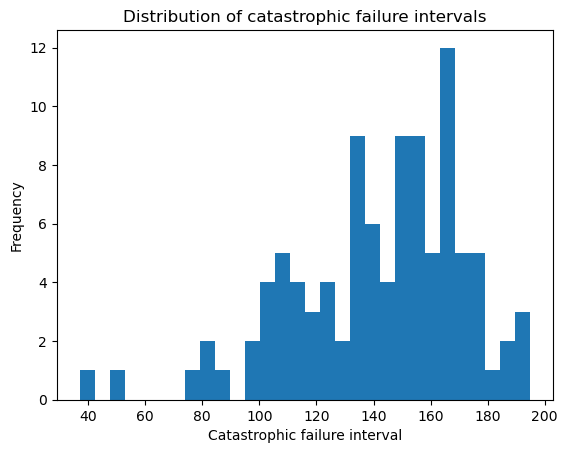

In [445]:
# the expected time between catastrophic failures
cas_records = results_df[results_df['event_type_label']=='Catastrophic']
print(cas_records.shape)
# Sort data
cas_records = cas_records.sort_values(['machine_id', 'abs_event_time'])


cas_records["cat_interval"] = (
    cas_records
    .groupby("machine_id")["abs_event_time"]
    .diff()
)
# Replace NaN (first event per machine) with abs_event_time itself
cas_records["cat_interval"] = cas_records["cat_interval"].fillna(
    cas_records["abs_event_time"]
)
all_intervals = cas_records["cat_interval"]

interval_summary = {
    "count": all_intervals.count(),
    "mean": all_intervals.mean(),
    "std": all_intervals.std(),
    "min": all_intervals.min(),
    "max": all_intervals.max()
}

print(interval_summary)

all_intervals.describe()

import matplotlib.pyplot as plt

plt.hist(all_intervals, bins=30)
plt.xlabel("Catastrophic failure interval")
plt.ylabel("Frequency")
plt.title("Distribution of catastrophic failure intervals")
plt.show()

In [446]:
cas_records

,machine_id,abs_event_time,event_type,censor_status,event_cost,fixed_cov_1,fixed_cov_2,dynamic_cov_1_at_failure,dynamic_cov_2_at_failure,event_type_label,cat_interval
6,1,108.0,-1,1,107.398384,1,1,0.780135,-1.206649,Catastrophic,108.0
23,2,178.0,-1,1,81.498513,2,0,1.204179,1.103735,Catastrophic,178.0
30,3,105.0,-1,1,93.395191,0,1,0.758159,0.053022,Catastrophic,105.0
46,4,132.0,-1,1,110.325538,1,1,0.828558,-0.589239,Catastrophic,132.0
56,5,150.0,-1,1,93.254004,0,1,1.241841,0.334452,Catastrophic,150.0
...,...,...,...,...,...,...,...,...,...,...,...
1230,96,104.0,-1,1,114.120342,0,1,0.772008,0.316338,Catastrophic,104.0
1243,97,151.0,-1,1,166.389374,3,1,1.245120,0.655443,Catastrophic,151.0
1255,98,161.0,-1,1,91.881317,2,1,0.868788,2.202849,Catastrophic,161.0
1264,99,109.0,-1,1,90.441516,0,0,0.807565,-0.828673,Catastrophic,109.0


(382, 10)
{'count': np.int64(382), 'mean': np.float64(39.282722513089006), 'std': 35.58124288247822, 'min': 1.0, 'max': 180.0}


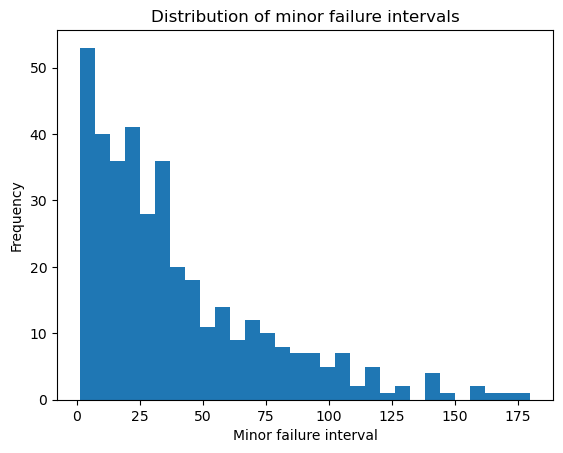

In [447]:
# Extract minor failure events
minor_records = results_df[results_df['event_type_label'].str.contains('minor', case=False, na=False)]
print(minor_records.shape)
# Sort data
minor_records = minor_records.sort_values(['machine_id', 'abs_event_time'])


minor_records["min_interval"] = (
    minor_records
    .groupby("machine_id")["abs_event_time"]
    .diff()
)
# Replace NaN (first event per machine) with abs_event_time itself
minor_records["min_interval"] = minor_records["min_interval"].fillna(
    minor_records["abs_event_time"]
)
all_intervals = minor_records["min_interval"]

interval_summary = {
    "count": all_intervals.count(),
    "mean": all_intervals.mean(),
    "std": all_intervals.std(),
    "min": all_intervals.min(),
    "max": all_intervals.max()
}

print(interval_summary)

all_intervals.describe()

import matplotlib.pyplot as plt

plt.hist(all_intervals, bins=30)
plt.xlabel("Minor failure interval")
plt.ylabel("Frequency")
plt.title("Distribution of minor failure intervals")
plt.show()

In [448]:
minor_records.sort_values(by="min_interval")[['machine_id','abs_event_time','min_interval']][:20]

,machine_id,abs_event_time,min_interval
1092,85,52.0,1.0
167,14,46.0,1.0
147,12,141.0,1.0
998,78,131.0,1.0
235,19,155.0,1.0
603,47,8.0,1.0
220,18,148.0,1.0
795,62,137.0,1.0
556,43,64.0,1.0
382,30,149.0,1.0


In [452]:
minor_records.reset_index(drop=True)

,machine_id,abs_event_time,event_type,censor_status,event_cost,fixed_cov_1,fixed_cov_2,dynamic_cov_1_at_failure,dynamic_cov_2_at_failure,event_type_label,min_interval
0,1,39.0,2,1,48.965171,1,1,0.964443,0.838014,Minor_2,39.0
1,1,73.0,2,1,50.164423,1,1,0.795821,-0.035713,Minor_2,34.0
2,1,112.0,3,1,88.750131,1,1,0.933755,-0.946404,Minor_3 (combo 1&2),39.0
3,1,156.0,3,1,105.960559,1,1,1.113909,1.061073,Minor_3 (combo 1&2),44.0
4,2,30.0,1,1,52.080935,2,0,1.241841,1.244387,Minor_1,30.0
...,...,...,...,...,...,...,...,...,...,...,...
377,99,59.0,3,1,131.489273,0,0,1.227992,-0.241183,Minor_3 (combo 1&2),59.0
378,100,20.0,1,1,42.476344,2,2,0.843407,0.982396,Minor_1,20.0
379,100,138.0,1,1,82.498965,2,2,0.780135,-1.416197,Minor_1,118.0
380,100,142.0,2,1,55.530345,2,2,0.933755,-1.465300,Minor_2,4.0


## Save dataset

In [453]:
results_df

,machine_id,abs_event_time,event_type,censor_status,event_cost,fixed_cov_1,fixed_cov_2,dynamic_cov_1_at_failure,dynamic_cov_2_at_failure,event_type_label
0,1,25.0,-2,1,72.305814,1,1,1.085247,1.078288,PM
1,1,39.0,2,1,48.965171,1,1,0.964443,0.838014,Minor_2
2,1,50.0,-2,1,33.533932,1,1,0.843407,-0.231118,PM
3,1,73.0,2,1,50.164423,1,1,0.795821,-0.035713,Minor_2
4,1,75.0,-2,1,40.368908,1,1,0.758159,0.147440,PM
...,...,...,...,...,...,...,...,...,...,...
1277,100,150.0,-2,1,42.489999,2,2,1.241841,0.334452,PM
1278,100,175.0,-2,1,38.725014,2,2,1.085247,1.940093,PM
1279,100,180.0,2,1,31.718708,2,2,1.241841,1.166761,Minor_2
1280,100,188.0,-1,1,83.029877,2,2,1.015687,-0.248559,Catastrophic


In [454]:
#results_df.to_csv('simulated dataset/tbm_PM.csv', index=False)

In [450]:
cas_records = cas_records.reset_index(drop=True)

In [457]:
cas_records

,machine_id,abs_event_time,event_type,censor_status,event_cost,fixed_cov_1,fixed_cov_2,dynamic_cov_1_at_failure,dynamic_cov_2_at_failure,event_type_label,cat_interval
0,1,108.0,-1,1,107.398384,1,1,0.780135,-1.206649,Catastrophic,108.0
1,2,178.0,-1,1,81.498513,2,0,1.204179,1.103735,Catastrophic,178.0
2,3,105.0,-1,1,93.395191,0,1,0.758159,0.053022,Catastrophic,105.0
3,4,132.0,-1,1,110.325538,1,1,0.828558,-0.589239,Catastrophic,132.0
4,5,150.0,-1,1,93.254004,0,1,1.241841,0.334452,Catastrophic,150.0
...,...,...,...,...,...,...,...,...,...,...,...
95,96,104.0,-1,1,114.120342,0,1,0.772008,0.316338,Catastrophic,104.0
96,97,151.0,-1,1,166.389374,3,1,1.245120,0.655443,Catastrophic,151.0
97,98,161.0,-1,1,91.881317,2,1,0.868788,2.202849,Catastrophic,161.0
98,99,109.0,-1,1,90.441516,0,0,0.807565,-0.828673,Catastrophic,109.0


In [456]:
#cas_records.to_csv('simulated dataset/tbm_rtf.csv', index=False)

In [364]:

############## --- Create Time-Series Format Dataset --- #############

def create_timeseries_data(n_machines, m, fixed_covs, 
                          all_machines_dynamic_covs, results_df):
    """
    Create time-series format dataset: one row per time point per machine
    
    Parameters:
    -----------
    n_machines : int
        Number of machines
    t_obs : float
        Observation time
    delta_t : float
        Time discretization
    fixed_covs : np.ndarray
        Fixed covariates (n_machines, n_fixed_features)
    all_machines_dynamic_covs : dict
        Dynamic covariates for each machine
    results_df : pd.DataFrame
        Event data from simulation
    
    Returns:
    --------
    pd.DataFrame : Time-series format with columns:
        - machine_id
        - time_index
        - time
        - location (fixed)
        - environment (fixed)
        - load_factor (dynamic)
        - usage_intensity (dynamic)
        - event_occurred (0/1)
        - event_type (if event occurred)
        - event_cost (if event occurred)
    """
    
    all_rows = []
    
    for machine_id in range(1, n_machines + 1):
        # Get this machine's events
        machine_events = results_df[results_df['machine_id'] == machine_id].copy()
        
        # Get this machine's dynamic covariates
        if machine_id in all_machines_dynamic_covs:
            machine_dyn_covs = all_machines_dynamic_covs[machine_id]
        else:
            # If not found, create empty array
            machine_dyn_covs = np.zeros((m + 1, 2))
        
        # Create row for each time point
        for time_idx in range(m + 1):
            time = time_idx * delta_t
            
            # Basic info
            row = {
                'machine_id': machine_id,
                'time': time,
            }
            
            # Fixed covariates
            row['location'] = fixed_covs[machine_id - 1, 0]
            row['environment'] = fixed_covs[machine_id - 1, 1]
            
            # Dynamic covariates (columns 1 and 2; ignore column 0 which is trigger)
            row['load_factor'] = machine_dyn_covs[time_idx, 1]
            row['usage_intensity'] = machine_dyn_covs[time_idx, 2]
            
            # Check if any event occurred at this time
            events_at_time = machine_events[
                np.isclose(machine_events['abs_event_time'], time, atol=delta_t/2)
            ]
            
            if len(events_at_time) > 0:
                # Event occurred
                event = events_at_time.iloc[0]  # Take first if multiple
                row['event_occurred'] = 1
                row['event_type'] = event['event_type']
                row['event_type_label'] = event['event_type_label']
                row['event_cost'] = event['event_cost']
                row['censor_status'] = event['censor_status']
            else:
                # No event
                row['event_occurred'] = 0
                row['event_type'] = np.nan
                row['event_type_label'] = ''
                row['event_cost'] = 0.0
                row['censor_status'] = np.nan
            
            all_rows.append(row)
    
    df_timeseries = pd.DataFrame(all_rows)
    
    # Convert types
    df_timeseries['event_type'] = df_timeseries['event_type'].astype('Int64')  # Nullable int
    df_timeseries['censor_status'] = df_timeseries['censor_status'].astype('Int64')
    
    return df_timeseries

In [442]:
df_timeseries = create_timeseries_data(
    n_machines, m, fixed_covs, 
    all_machines_dynamic_covs, results_df
)

In [298]:
df_timeseries

,machine_id,time,location,environment,load_factor,usage_intensity,event_occurred,event_type,event_type_label,event_cost,censor_status
0,1,0.0,1,1,1.000000,-0.082541,0,<NA>,,0.000000,<NA>
1,1,1.0,1,1,1.062374,-0.261131,0,<NA>,,0.000000,<NA>
2,1,2.0,1,1,1.122021,0.060047,0,<NA>,,0.000000,<NA>
3,1,3.0,1,1,1.176336,0.428186,0,<NA>,,0.000000,<NA>
4,1,4.0,1,1,1.222943,0.420720,0,<NA>,,0.000000,<NA>
...,...,...,...,...,...,...,...,...,...,...,...
20095,100,196.0,2,2,0.937626,-0.690464,0,<NA>,,0.000000,<NA>
20096,100,197.0,2,2,0.877979,-1.035166,0,<NA>,,0.000000,<NA>
20097,100,198.0,2,2,0.823664,-0.768683,0,<NA>,,0.000000,<NA>
20098,100,199.0,2,2,0.777057,0.064132,0,<NA>,,0.000000,<NA>


In [443]:
#df_timeseries.to_csv('simulated dataset/tbm_timeseries.csv', index=False)